### 1. 라이브러리 설치

- python의 self-organizing map 라이브러리인 [minisom](https://github.com/JustGlowing/minisom) 활용

- 주석처리 단축키: Ctrl + /

In [1]:
!pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.1-py3-none-any.whl size=10589 sha256=90cb70c7e0ebb04b7659febcb19774bc94c67411278b495d02e4247ecdcc85d2
  Stored in directory: /root/.cache/pip/wheels/c7/92/d2/33bbda5f86fd8830510b16aa98c8dd420129b5cb24248fd6db
Successfully built minisom


In [2]:
!pip install descartes

- shapely의 경우 1.8.4 혹은 1.8.5 버전 사용
- 발생하는 ERROR 내역 무시

In [3]:
!pip uninstall shapely -y
!pip install shapely==1.8.5

Found existing installation: shapely 2.0.2
Uninstalling shapely-2.0.2:
  Successfully uninstalled shapely-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


### 2. Import Files

In [4]:
# [1] 파일 직접 업로드
from google.colab import files
file_uploaded = files.upload()

Saving data_train.csv to data_train.csv


### 3. 라이브러리

In [5]:
from typing import List, Tuple, Any

# Data
import numpy as np
import pandas as pd

# Clustering and Classification
from minisom import MiniSom
from scipy.cluster.hierarchy import ward, fcluster, dendrogram, linkage
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import minmax_scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV

# Plot
from shapely.geometry import box
import shapely.geometry
import shapely.ops as so
from descartes import PolygonPatch
import matplotlib.pyplot as plt
import matplotlib as mpl

import warnings
warnings.filterwarnings(action='ignore')

In [6]:
# plt.rcParams.update({'font.size': 12})

### 4. 데이터 호출 함수

In [7]:
def load_data(filepath, column_name_list) -> Tuple[np.ndarray, List[str]]:
    csv_data = pd.read_csv(filepath)
    chemical_list: List[str] = csv_data["micropollutant"].tolist()

    chemical_idx: List[int] = []
    return_name: List[str] = []
    for i, chemical in enumerate(chemical_list):
        chemical_idx.append(i)
        return_name.append(chemical)

    # Chemical name list and index
    extracted_data: pd.DataFrame = csv_data.iloc[chemical_idx]

    output_data = extracted_data[column_name_list]

    # csv data (List[List[float]]) to numpy.
    return_data: np.ndarray = np.asarray(output_data.to_numpy())
    return return_data, return_name

### 5. Clutering Analysis 클래스

In [8]:
class ClusteringAnalysis:
    def __init__(self, neurons: List, parameters: List, sim_type: str, name: str,
                 filepath: str, column_name_list: List[str]):
        self.name = name
        self.sim_type = sim_type
        self.filepath = filepath
        self.column_name_list = column_name_list

        self.data_input, self.name_input = load_data(self.filepath, self.column_name_list)
        self.som_input = self.data_input.copy()
        self.som_input = ((self.som_input - np.min(self.som_input, axis=0)) /
                          (np.max(self.som_input, axis=0) - np.min(self.som_input, axis=0)))
        # numpy.ndarray to list
        self.som_input.tolist()

        # data normalization
        self.n_neurons = neurons[0]
        self.m_neurons = neurons[1]

        # clustering
        # Initialization and training
        self.som_clustering = MiniSom(self.n_neurons, self.m_neurons, self.som_input.shape[1],
                                      sigma=parameters[0], learning_rate=parameters[1],
                                      neighborhood_function='gaussian', random_seed=42)

        self.som_clustering.pca_weights_init(self.som_input)
        self.som_clustering.train(self.som_input, 1000, verbose=True)  # random training

        # ward_method
        self.num_cluster = 0
        self.labels: np.ndarray = np.zeros(len(self.name_input))
        self.cluster_ward_rev: np.ndarray = np.zeros([self.n_neurons, self.m_neurons])
        self.position: List = []

    def ward_method(self, num_cluster: int) -> np.ndarray:
        # data pretreatment
        self.num_cluster = num_cluster
        x_ward = self.som_clustering.get_weights()
        x_ward_rev = x_ward.reshape((self.n_neurons * self.m_neurons), len(self.column_name_list))
        y_ward = pdist(x_ward_rev)
        z_ward = ward(y_ward)

        cluster_ward = fcluster(z_ward, self.num_cluster, criterion='maxclust')
        self.cluster_ward_rev = cluster_ward.reshape(self.n_neurons, self.m_neurons)

        self.position: List = []
        for cnt, xx in enumerate(self.som_input):
            w = self.som_clustering.winner(xx)
            wx, wy = self.som_clustering.convert_map_to_euclidean(w)

            self.labels[cnt] = self.cluster_ward_rev[int(wx), int(wy)]
            self.position.append([self.name_input[cnt], self.labels[cnt], int(wx), int(wy)])
        return self.labels

    def num_cluster_calculation(self, start_num: int, end_num: int, print_dbi: bool = False):
        end_num = end_num + 1
        dbi: np.ndarray = np.zeros([end_num, 1])
        silhouette: np.ndarray = np.zeros([end_num, 1])
        for num_cluster in range(start_num, end_num):
            labels = self.ward_method(num_cluster)

            dbi[num_cluster] = davies_bouldin_score(self.som_input, labels)
            silhouette[num_cluster] = silhouette_score(self.som_input, labels)

            if print_dbi:
                print(f"clusters: {num_cluster}, Davies-Bouldin Score: {dbi[num_cluster, 0]:.3f}")

        num_cluster: int = int(np.argmin(dbi[start_num:end_num])) + start_num
        print(f"minimum dbi - clusters: {num_cluster}, Davies-Bouldin Score: {dbi[num_cluster, 0]:.3f}")
        print()
        return num_cluster, dbi, silhouette

### 6. Clutering Analysis 실행

In [9]:
filepath = './data_train.csv'
column_name_phychemi: List[str] = ["MW", "LogKow", "Alcohol", "Alkyl aryl ether",
                                   "Carboxylic acid", "Ester", "Sulfur",
                                   "Amine", "N-others", "Amide", "Halogen",
                                   "Aromatic"]

sim_type = 'Aerobic'
column_name_KdKbio: List[str] = ["Kd", "kbio"]
column_name_KdKbio = [i + '_' + sim_type for i in column_name_KdKbio]
column_name_total: List[str] = column_name_phychemi + column_name_KdKbio

In [10]:
n_neurons: int = 10
m_neurons: int = 10
sigma: float = 5
learning_rate: float = 0.1
max_cluster: int = n_neurons * m_neurons
max_cluster: int = 20
scenario_type: str = 'physicochemical'
rs: int = 42  # 43 MPs

print(f"sim type      : {sim_type}")
print(f"scenario type : {scenario_type}")
print(f"n_neurons     : {n_neurons}")
print(f"m_neurons     : {m_neurons}")
print(f"sigma         : {sigma}")
print(f"learning_rate : {learning_rate}")
print(f"max_cluster   : {max_cluster}")
print(f"rs            : {rs}")

sim type      : Aerobic
scenario type : physicochemical
n_neurons     : 10
m_neurons     : 10
sigma         : 5
learning_rate : 0.1
max_cluster   : 20
rs            : 42


In [11]:
# clustering
cls_phychemi = ClusteringAnalysis([n_neurons, m_neurons], [sigma, learning_rate],
                                    sim_type, scenario_type,
                                    filepath, column_name_phychemi)
num_cluster_phychemi, dbi_phychemi, silhouette = cls_phychemi.num_cluster_calculation(5, max_cluster)
num_cluster_phychemi = 10
labels_phychemi = cls_phychemi.ward_method(num_cluster_phychemi)

cls_phychemi_idx = cls_phychemi.cluster_ward_rev.T.copy()

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.5210016236100783
minimum dbi - clusters: 20, Davies-Bouldin Score: 0.451



### 7. 분석 결과 그래프

In [12]:
def draw_som_distance_map(self, draw_axis: bool = False, print_name: bool = True) -> None:
    figure_name = self.sim_type + " " + self.name + " distance map"
    plt.figure(figure_name, figsize=(9, 9))
    plt.pcolor(self.som_clustering.distance_map().T, cmap='Spectral')
    if draw_axis:
        pass
    else:
        plt.axis("off")

    if print_name:
        self.print_name()
        str_name = "_w_name"
    else:
        str_name = "_wo_name"
    plt.show()

def print_name(self) -> None:
    list_pos: List = []
    for cnt, xx in enumerate(self.som_input):
        w = self.som_clustering.winner(xx)
        wx, wy = self.som_clustering.convert_map_to_euclidean(w)
        list_pos.append([wx, wy])

    for cnt, xx in enumerate(self.som_input):
        w = self.som_clustering.winner(xx)
        wx, wy = self.som_clustering.convert_map_to_euclidean(w)

        if list_pos.count([wx, wy]) == 2:
            wy_bias = 0.2
            list_pos.remove([wx, wy])
        elif list_pos.count([wx, wy]) == 3:
            wy_bias = - 0.2
            list_pos.remove([wx, wy])
        elif list_pos.count([wx, wy]) == 4:
            wy_bias = + 0.4
            list_pos.remove([wx, wy])
        elif list_pos.count([wx, wy]) == 5:
            wy_bias = - 0.4
            list_pos.remove([wx, wy])
        elif list_pos.count([wx, wy]) == 6:
            wy_bias = + 0.6
            list_pos.remove([wx, wy])
        elif list_pos.count([wx, wy]) == 7:
            wy_bias = - 0.6
            list_pos.remove([wx, wy])
        elif list_pos.count([wx, wy]) == 8:
            wy_bias = - 0.8
            list_pos.remove([wx, wy])
        elif list_pos.count([wx, wy]) == 9:
            wy_bias = - 1.0
            list_pos.remove([wx, wy])
        else:
            wy_bias = 0.0

        plt.text(wx + 0.5, wy + wy_bias + 0.4, self.name_input[cnt], ha='center', va='center')

ClusteringAnalysis.draw_som_distance_map = draw_som_distance_map
ClusteringAnalysis.print_name = print_name

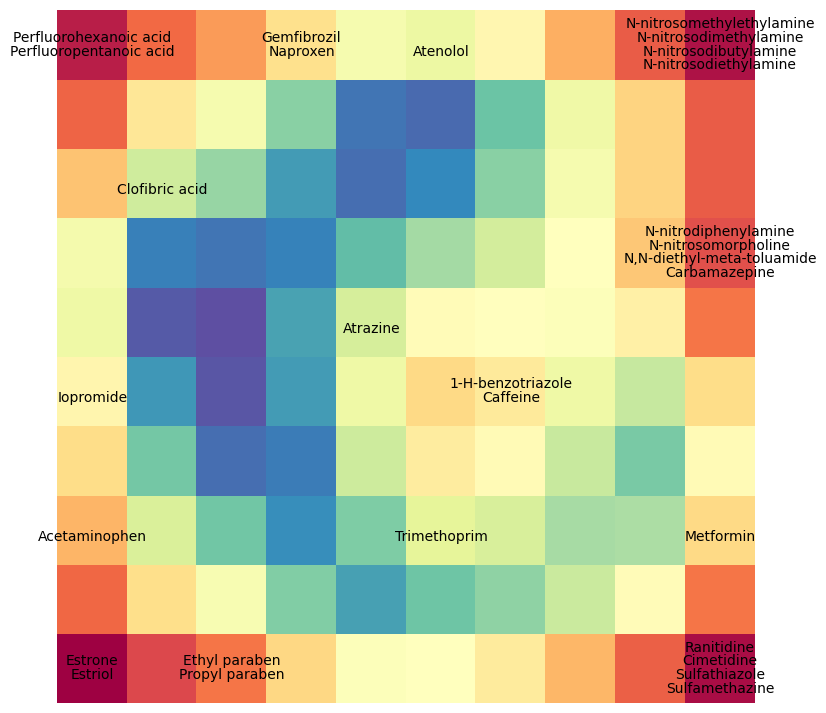

In [13]:
cls_phychemi.draw_som_distance_map(draw_axis=False, print_name=True)

In [14]:
def draw_ward_clustering(self, draw_axis: bool = False) -> None:
    figure_name = self.sim_type + " " + self.name + " ward clustering"
    plt.figure(figure_name, figsize=(9, 9), frameon=False)
    plt.pcolor(self.cluster_ward_rev.T, cmap='Spectral')

    if draw_axis:
        pass
    else:
        plt.axis("off")

    self.print_name()
    plt.show()

ClusteringAnalysis.draw_ward_clustering = draw_ward_clustering

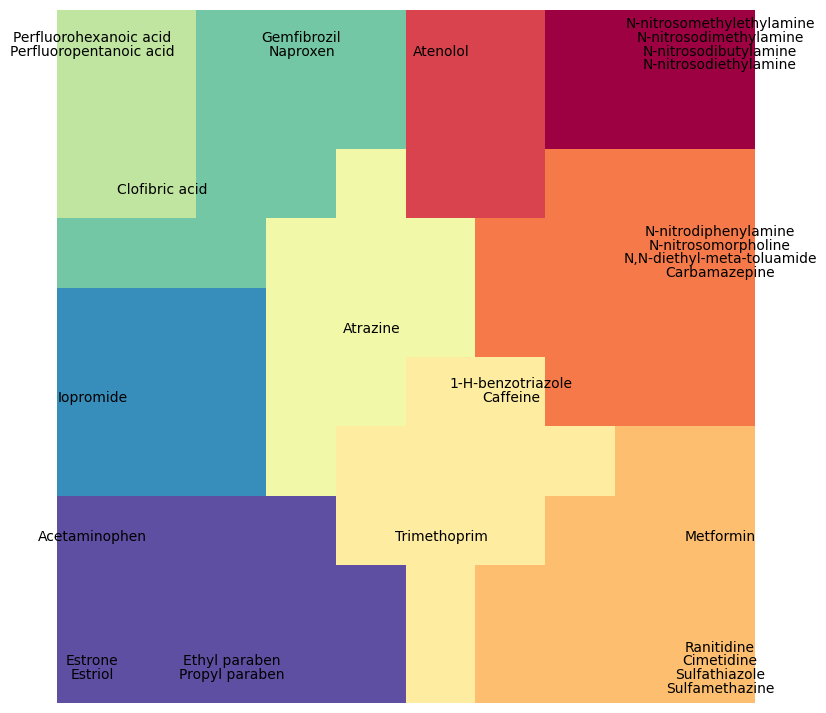

In [15]:
cls_phychemi.draw_ward_clustering(draw_axis=False)

In [16]:
def draw_clustering_boundary(self, cluster_boundary_index: np.ndarray, draw_axis: bool = "False") -> None:
    figure_name = self.sim_type + " " + self.name + " clustering boundary"
    fig_obj = plt.figure(figure_name, figsize=(9, 9), frameon=False)

    plt.xlim(0, self.n_neurons)
    plt.ylim(0, self.m_neurons)
    boundary_shift: Tuple[float, float] = (0, 1)

    for k in range(len(np.unique(cluster_boundary_index))):
        rect_list: List[shapely.geometry.box] = []
        for i in range(cluster_boundary_index.shape[0]):
            for j in range(cluster_boundary_index.shape[1]):
                if cluster_boundary_index[i, j] == (k + 1):
                    rect = box(j + boundary_shift[0], i + boundary_shift[0],
                                j + boundary_shift[1], i + boundary_shift[1])
                    rect_list.append(rect)

        new_shape = so.unary_union(rect_list)
        ax = fig_obj.gca()
        ax.add_patch(PolygonPatch(new_shape, ec='black',
                                    fill=False, linewidth=2, zorder=2))

    if draw_axis:
        pass
    else:
        plt.axis("off")

    plt.show()

ClusteringAnalysis.draw_clustering_boundary = draw_clustering_boundary

In [17]:
# cls_phychemi.draw_clustering_boundary(cls_phychemi_idx, draw_axis=False)

In [18]:
def draw_codes_plot(self):
    figure_name = self.sim_type + " " + self.name + " code vector plot"
    fig_obj = plt.figure(figure_name, figsize=(9, 9), frameon=False)

    data = self.som_clustering.get_weights().copy()
    (row_len, col_len, depth_len) = data.shape
    data = data.reshape(row_len * col_len, depth_len)
    data = minmax_scale(data, axis=0)

    ncol: int = int(np.sqrt(data.shape[0]))
    nrow: int = int(np.sqrt(data.shape[0]))

    nvector: int = int(data.shape[1])
    facecolors: List = []
    cmap = mpl.colormaps["jet"]

    for idx in range(nvector):
        facecolors.append(cmap(0.05 + 1 / nvector * idx))

    position: np.ndarray = np.zeros([nrow, ncol])
    cnt: int = 1
    for row in range(nrow):
        for col in range(ncol):
            position[col, (nrow - 1) - row] = cnt
            cnt += 1
    position = position.reshape(nrow * ncol)

    for cnt in range(ncol * nrow):
        ax = fig_obj.add_subplot(nrow, ncol, int(position[cnt]), polar=True)
        num = len(data[0])
        theta = np.arange(0.0, 2 * np.pi, 2 * np.pi / num)
        radii = data[cnt]
        width = np.pi / (num / 2)
        bars = plt.bar(theta, radii, width=width, bottom=0.0)

        idx = 0
        for bar, label in zip(bars, self.column_name_list):
            bar.set_facecolor(facecolors[idx])
            bar.set_alpha(0.5)

            if cnt == int(nrow * nrow / 2):
                bar.set_label(label)
                ax.legend(loc='upper center',
                            bbox_to_anchor=(0, -2),
                            fancybox=True,
                            shadow=True, ncol=5)
            idx += 1

        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(False)

    fig_obj.subplots_adjust(hspace=0, wspace=0)
    plt.show()

ClusteringAnalysis.draw_codes_plot = draw_codes_plot

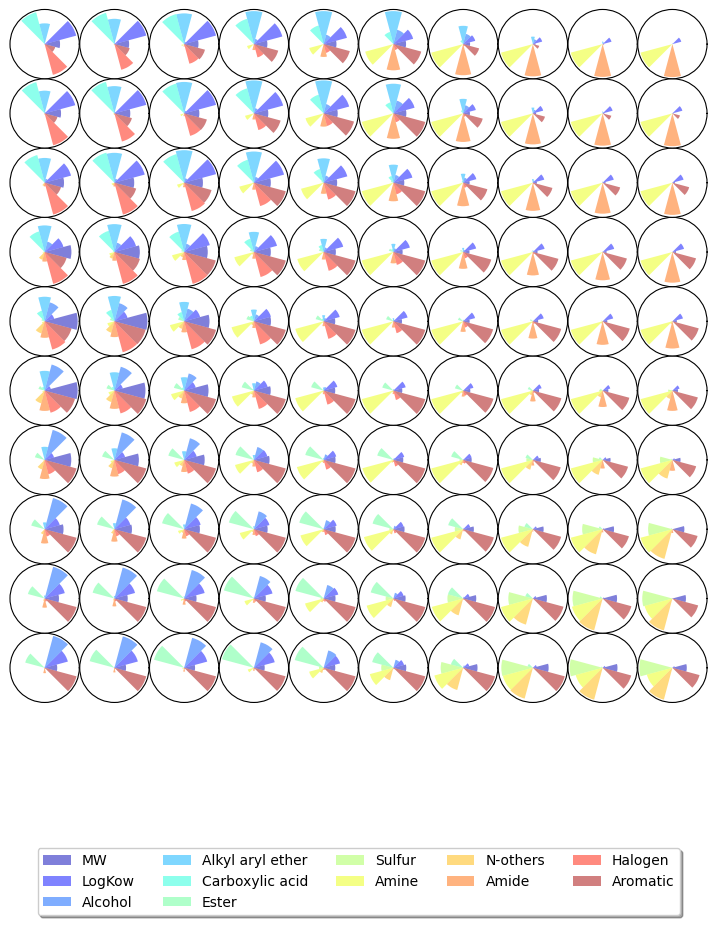

In [19]:
cls_phychemi.draw_codes_plot()

In [20]:
def draw_dendrogram(self, draw_axis: bool = False) -> None:
    figure_name = self.sim_type + " " + self.name + " dendrogram"

    plt.figure(figure_name, figsize=(5, 5), frameon=False)
    linked = linkage(self.som_input, method='ward')

    hierarchy.set_link_color_palette(['k'])

    dendrogram(linked,
                orientation='top',
                above_threshold_color='k',
                labels=self.name_input,
                distance_sort='descending',
                show_leaf_counts=True,
                leaf_rotation=90)
    plt.show()

ClusteringAnalysis.draw_dendrogram = draw_dendrogram

In [21]:
# cls_phychemi.draw_dendrogram()

### 8. 분류 알고리즘

In [22]:
class ClassificationAnalysis:
    def __init__(self, ml_model: Any, name: str, labels,
                 filepath_train, input_name_list, output_name_list):
        self.input_name_list = input_name_list

        self.data, self.name_input = load_data(filepath_train, input_name_list)

        self.ml_model = ml_model
        self.name = name
        self.labels = pd.Series(labels)
        X_train, X_test, y_train, y_test = train_test_split(self.data, labels,
                                                            test_size=0.3, random_state=42)
        self.X_train = pd.DataFrame(X_train, columns=input_name_list)
        self.X_test = pd.DataFrame(X_test, columns=input_name_list)
        self.y_train = pd.DataFrame(y_train)
        self.y_test = pd.DataFrame(y_test)

        self.ml_train = None
        self.ml_test = None

    def train_and_test(self, display_train=False, display_test=False) -> None:
        print(f"=== Classification: {self.name} ===")
        self.ml_model.fit(self.X_train.values, self.y_train.values)

        self.ml_train = self.ml_model.predict(self.X_train.values)
        self.ml_test = self.ml_model.predict(self.X_test.values)

        if display_train:
            print("=== Train ===")
            print(classification_report(self.y_train.values, self.ml_train))

        if display_test:
            print("=== Test ===")
            print(classification_report(self.y_test.values, self.ml_test))
            print('\n')

    def train_and_test_cross_validation(self) -> None:
        scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

        n = 5
        kfold = KFold(n_splits=n)
        print("=== Cross Validation ===")
        print(f"kfold         : {n}")

        results = cross_validate(estimator=self.ml_model,
                                 X=self.data,
                                 y=self.labels.values,
                                 cv=kfold,
                                 scoring=scoring)

        print(f"avg. accuracy : {results['test_accuracy'].mean():.2f}")
        print(f"avg. f1       : {results['test_f1_macro'].mean():.2f}")
        print(f"avg. precision: {results['test_precision_macro'].mean():.2f}")
        print(f"avg. recall   : {results['test_recall_macro'].mean():.2f}")

        print(f"std. accuracy : {results['test_accuracy'].std():.2f}")
        print(f"std. f1       : {results['test_f1_macro'].std():.2f}")
        print(f"std. precision: {results['test_precision_macro'].std():.2f}")
        print(f"std. recall   : {results['test_recall_macro'].std():.2f}")
        print()

### 9. 분류 알고리즘 결과

In [23]:
clf_phychemi = ClassificationAnalysis(RandomForestClassifier(random_state=rs), "RandomForestClassifier",
                                      labels_phychemi, filepath, column_name_phychemi,
                                      column_name_KdKbio)
clf_phychemi.train_and_test(display_train=True, display_test=True)
clf_phychemi.train_and_test_cross_validation()

=== Classification: RandomForestClassifier ===
=== Train ===
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         3
         2.0       1.00      1.00      1.00         1
         3.0       1.00      1.00      1.00         3
         4.0       1.00      1.00      1.00         3
         5.0       1.00      1.00      1.00         3
         6.0       1.00      1.00      1.00         1
         7.0       1.00      1.00      1.00         2
         8.0       1.00      1.00      1.00         1
        10.0       1.00      1.00      1.00         3

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

=== Test ===
              precision    recall  f1-score   support

         1.0       0.50      1.00      0.67         1
         2.0       0.00      0.00      0.00         0
         3.0       1.00      1.00      1.00         1
    

### 관련 링크

- [Clustering micropollutants and estimating rate constants of sorption and biodegradation using machine learning approaches](https://www.nature.com/articles/s41545-023-00282-6)

- [GitHub](https://github.com/meticulousdev)